# CS4248 Project Group 23

In [4]:
import pandas as pd
from sklearn.metrics import f1_score
import numpy as np
import tensorflow as tf

In [5]:
import gensim.downloader as api

def load_glove_model():
    glove_model = api.load('glove-wiki-gigaword-50')
    print("Done.",len(glove_model)," words loaded!")
    return glove_model, glove_model.vector_size

glove_model, glove_dim = load_glove_model()

Done. 400000  words loaded!


In [6]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/t1dus/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [7]:
MAX_LEN = 100

In [8]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_text(text):
    # Lowercase text
    text = text.lower()
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # tokenize
    words = word_tokenize(text)
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words][:MAX_LEN]
    # Get the GloVe vectors
    vectors = [glove_model[word] if word in glove_model else np.zeros(glove_model.vector_size) for word in words]
    vectors = vectors + [np.zeros(glove_model.vector_size)] * (MAX_LEN - len(vectors))
    # If vectors is empty, return a vector of zeros
    return np.array(vectors)

In [9]:
train = pd.read_csv("./raw_data/fulltrain.csv")
x_train = train.iloc[:, 1].values 
y_train = train.iloc[:, 0].values == 4 # true => trusted

In [10]:
x_train = np.array([preprocess_text(text) for text in x_train])

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

model = Sequential([
    Bidirectional(LSTM(64)),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [13]:
# train val set
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [14]:
history = model.fit(x_train, y_train, batch_size = 32, epochs = 3, validation_data=(x_val, y_val))

Epoch 1/3


2024-04-18 18:08:49.933758: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 781640000 exceeds 10% of free system memory.


1221/1222 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - acc: 0.8816 - loss: 0.3015

2024-04-18 18:09:52.373544: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 195420000 exceeds 10% of free system memory.


1222/1222 ━━━━━━━━━━━━━━━━━━━━ 67s 53ms/step - acc: 0.8816 - loss: 0.3014 - val_acc: 0.9393 - val_loss: 0.1679
Epoch 2/3
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 63s 51ms/step - acc: 0.9398 - loss: 0.1545 - val_acc: 0.9497 - val_loss: 0.1320
Epoch 3/3
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 64s 52ms/step - acc: 0.9567 - loss: 0.1146 - val_acc: 0.9549 - val_loss: 0.1217


dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


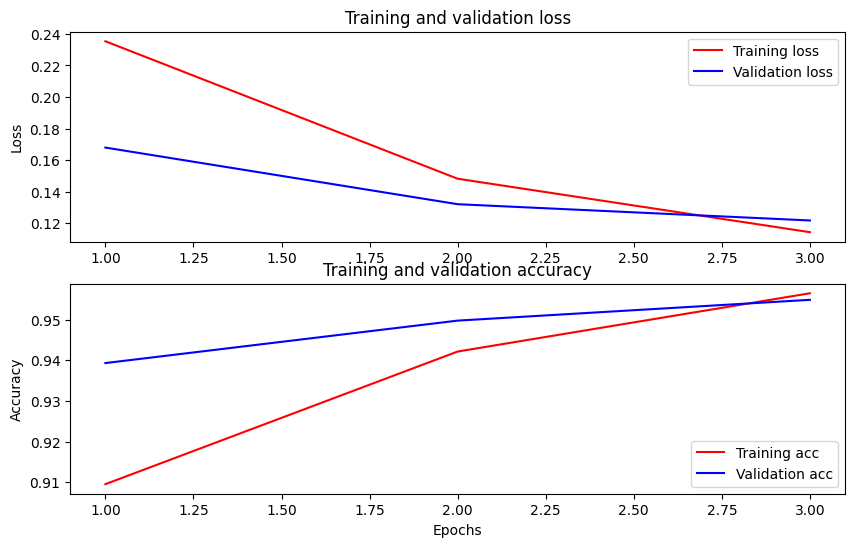

In [15]:
import matplotlib.pyplot as plt
history_dict = history.history
print(history_dict.keys())

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [16]:
# get the training error

# print for the train set f1 score is
y_pred = np.round(model.predict(x_train))
print("Train Set: " + str(f1_score(y_train, y_pred, average='macro')))

# print for the val set f1 score is
y_pred = np.round(model.predict(x_val))
print("Val Set: " + str(f1_score(y_val, y_pred, average='macro')))

2024-04-18 18:12:06.195108: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 781640000 exceeds 10% of free system memory.


1222/1222 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step
Train Set: 0.9489224505133886
  7/306 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step

2024-04-18 18:12:29.113307: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 195420000 exceeds 10% of free system memory.


306/306 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Val Set: 0.9290501629215846


In [17]:
# get the prediction for the test set
test = pd.read_csv('./raw_data/balancedtest.csv')
x_test = np.array([preprocess_text(text) for text in test.iloc[:, 1]])
y_test = test.iloc[:, 0].values == 4 # subtract 1 to make the labels 0-based

y_pred = np.round(model.predict(x_test))

# get the f1 score
f1_score_test = f1_score(y_test, y_pred, average='macro')
print(f1_score_test)

 7/94 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

2024-04-18 18:12:42.108610: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 59980000 exceeds 10% of free system memory.


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
0.7717682423357923


In [18]:
model.save(f'keras_models/LSTM_Glove_{f1_score_test}_.keras')